In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST

Neste capítulo, será usado o conjunto de dados MINST, composto de 70 mil imagens pequenas de algarismos escritos à 
mão.

O Scikit-Learn fornece muitas funções auxiliares para fazer o download de conjunto de dados populares. O MINST é um
deles. 

In [2]:
# O código a seguir obtém o conjunto de dados do MINST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

##### Acho que o conjunto de dados MNIST de openml foi recentemente (?) Comutado para retornar um DataFrame pandas em vez de um array numpy. Outra correção possível está na chamada de função:

mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
# import nltk
# import sklearn

# print('nltk version: {}.'.format(nltk.__version__))
# print('scikit-learn version: {}.'.format(sklearn.__version__))


##### Os conjuntos de dados carregados pela Scikit-Learn geralmente têm uma estrutura similar ao dicionário:

-> Uma chave DESCR que descreve o conjunto de dados.

-> Uma chave data que contém um array com uma linha por instância e uma coluna por característica.

-> Uma chave target que contém um array com os rótulos.

In [4]:
# Vamos conferir esses arrays:
X, y = mnist["data"], mnist["target"]

In [5]:
# X shape
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

##### Existem 70 mil imagens e cada uma delas apresenta 784 características.

Isso ocorre porque cada imagem tem 28 x 28 pixels, e cada característica representa simplesmente a intensidade de
um pixel, de 0(branco) e 255(preto).

Tudo que precisa fazer é pegar o vetor da característica de uma instância, remodelá-lo em um array de 28 x 28 e 
exibi-lo usando a função imshow() do Matplotlib

In [7]:
some_digit = X[0]

In [8]:
some_digit_image = some_digit.reshape(28, 28)

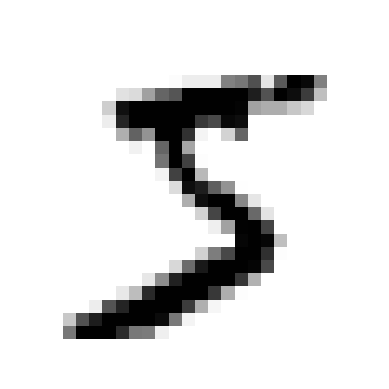

In [9]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [10]:
# O algarismo parece com um 5, e é justamente isso o que o rótulo nos informa:
y[0]

'5'

In [11]:
# Repare que o rótulo é uma string. A maioria dos algarismos de AM espera números, logo, converteremos y em inteiro
y =y.astype(np.uint8)

In [12]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [13]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


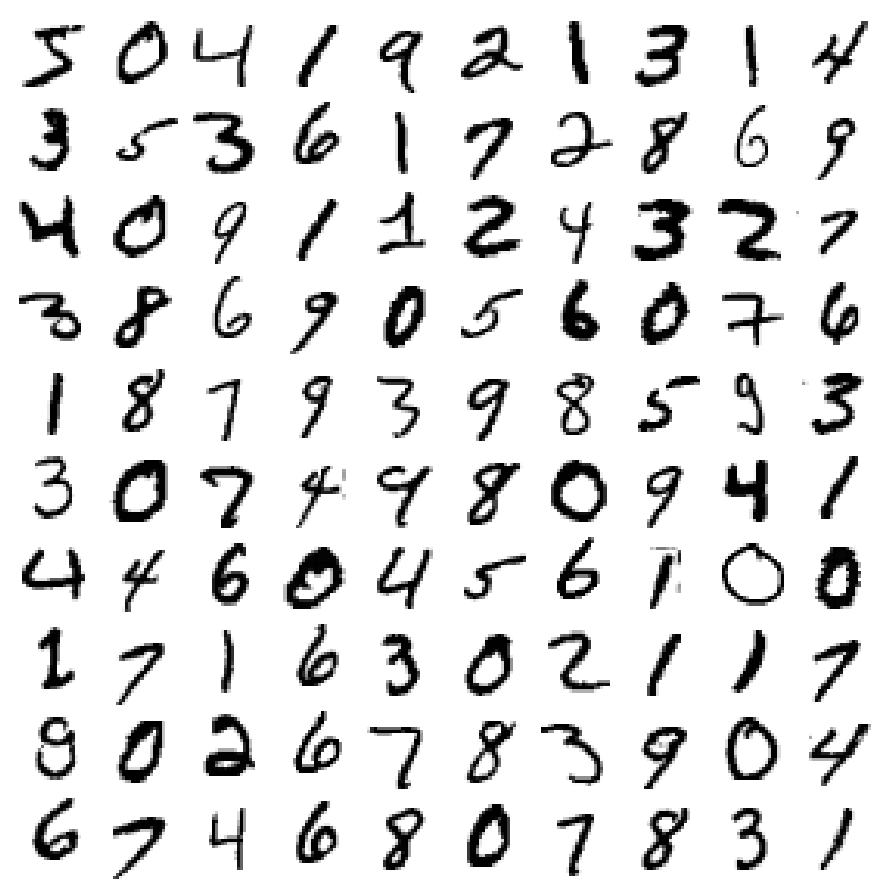

In [14]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

##### Sempre deve criar um conjunto de teste e separá-lo antes de inspecionar os dados com mais atenção

O conjunto de dados MNIST, na verdade, já está dividido em um conjunto em um conjunto de treinamento(as primeiras 
60 mil imagens) e em um conjunto de teste (as últimas 10 mil imagens):

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Treinando um Classificador Binário

Vamos simplificar as coisas e tentar identificar somente um algarismo - por exemplo, o número 5. Este "5-detector",
será um exemplo de classificador binário capaz de fazer distinções entre apenas duas classes, 5 e não-5

In [16]:
# Vamos criar os vetores-alvo para essa tarefa de classificação:
y_train_5 = (y_train == 5) # True para todos os 5s, False para todos outros
y_test_5 = (y_test == 5)

##### Vamos escolher um classificador e treiná-lo. 

Um bom ponto de partida é um classificador gradiente descendente estocástico (SGD), usando a classe SGDClassifier
da Scikit-Learn.A vantagem desse classificador é conseguir lidar eficientemente com conjunto de dados muito grandes
Isso ocorre em parte porque o SGD lida com instâncias de treinamento de forma independente, uma de cada vez
(o qu3e também torna o SGD adequado para o aprendizado online).

In [17]:
# Vamos criar um SGDClassifier e treiná-lo em todo o conjunto de treinamento:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

##### O SGDClassifier depende da aleatoriedade durante o treinamento 

Por isso, o nome "estocástico". Caso queira resultados que possam ser reproduzidos, defina o parâmetro random_state

In [18]:
# Agora podemos usá-lo para detectar imagens do número 5:
sgd_clf.predict([some_digit])

array([ True])

#### O classificador estima que esta imagem representa um 5(True). Pelo visto estimou corretamente!
Agora avaliaremos o desempenho desse modelo.

## Cálculo de Desempenho

Normalmente, avaliar um classificador é bem mais complicado do que avaliar um regressor; existem muitos cálculos e
medidas de desempenho disponíveis.

##### Cálculo de acurácia com a validação cruzada

Uma boa forma de avaliar um modelo é usar a validação cruzada

### Implementando a Validação Cruzada

Vez ou outra, precisará ter mais controle sobre o processo de validação cruzada do que a padronização Scikit-Learn pode oferecer. Nesses casos, você mesmo pode implementar a validação cruzada. 

O código a seguir faz basicamente a mesma coisa que a função "cross_val_score()" da Scikit-Learn e exibe o mesmo resultado.


In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # Exibe 0.9502, 0.96565, e 0.96495

0.9669
0.91625
0.96785


A classe StratifiedKfold realiza amostragem estratificada, com o objetivo de produzir folds que contêm uma proporção representativa de cada classe. 

A cada iteração, o código cria um clone do classificador, treina esse clone nos folds de treinamento e faz predições nos folds de teste. Em seguida, contabiliza o número de predições corretas e gera a proporção de predições corretas.

Usaremos a função "cross_val_score()" para avaliar o seu modelo SGDClassifier com o método k-fold de validação cruzada em três partes. 

Lembre-se de que método k-fold de validação cruzada significa dividir o conjunto de treinamento em k-folds (neste caso, três) e, depois, prever e avaliar predições em cada conjunto utilizando um modelo treinado nos folds restantes.

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Uau! Acurácia acima de 96% (proporção de predições corretas) em todos os folds de validação cruzada? Antes que fiquemos muito entusiasmado vejamos um classificador que deixa a desejar e somente classifica todas as imagens na classe "não-5"

In [21]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [22]:
# Consegue estimar a acurácia deste modelo?
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

É isso mesmo, mais de 90% de acurácia! Isso acontece simplesmente porque apenas cerca de 10% das imagens são "5", assim sendo, caso sempre estime que uma imagem não é um 5, terá razão em cerca de 90% das vezes.

Isso demonstra por que a acurácia geralmente não é a medida de desempenho preferida para os classificadores, sobretudo quando está manipulando conjunto de dados assimétricos(ou seja, quando algumas classes são muito mais frequentes que outras).

### Matriz de Confusão

Uma forma bem melhor de avaliar o desempenho de um classificador é analisar a matriz de confusão. A ideia geral é contabilizar o número de vezes que as instâncias da Classe A são classificadas como classe B.

Por exemplo, para saber o número de vezes que o classificador confundiu imagens de 5s com 3s, verificaria na quinta linha e na terceira coluna da matriz de confusão.

Para calcular a matriz de confusão, primeiro precisa ter o conjunto de predições de modo que elas possam ser comparadas às previsões reais, vamos usar a função "cross_val_predict()":

In [23]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

A função "cross_val_predict" => realiza o método k-fold de validação cruzada, em vez de retornar os scores de avaliação, ela retorna as predições feitas em cada teste de fold. 
Isso significa que obtém uma predição limpa para cada instância no conjunto de treinamento

Limpa => É quando a predição é feita por um modelo que nunca manipulou os dados durante o treinamento.

##### Agora está pronto para obter a matriz de confusão usando a função confusion_matrix()

Apenas passe as classes alvo(y_train_5) e as classes previstas(y_train_pred)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [25]:
# Fingir que alcaçamos a perfeição
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precisão e Revocação

A Scikit-Learn fornece diversas funções para calcular métricas classificadoras, incluindo Precisão e Revocação

In [26]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [27]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

In [28]:
# Para calcular a F score, basta chamar a função f1_score():
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Trade-off precisão/revocação

Com o intuito de entender o trade-off, vejamos como o "SGDClassifier" toma suas decisões de classificação. Para cada instância, ele calcula um score baseado em uma função de decisão e, se esse score for maior que um limiar, ele atribui a instância à classe positiva, ou então atribui  à classe negativa.


A Scikit-Learn não permite definir o limiar diretamente, mas o deixa acessar os scores de decisão que ela emprega para fazer predições.Em vez de chamar o método "decision_function()", que retorna um score para cada instância e, em seguida faz predições com base nesses scores usando qualquer limiar desejado:

In [29]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [30]:
threshold = 0 
y_some_digit_pred = (y_scores > threshold)

In [31]:
y_some_digit_pred

array([ True])

O SGDClassifier utiliza um limiar igual a 0, assim o código anterior retorna o mesmo resultado que o método predict() (ou seja, True). Vamos aumentar o limiar

In [32]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_some_digit_pred

array([False])

Isso comprova que aumentar o limiar diminui a revocação. A imagem representa um 5, e o classificador o detecta quando o limiar é 0, mas o perde quando o limiar sobe para 8 mil.

Como decide qual limiar usar? Primeiro, use a função "cross_val_predict()" para obter os scores de todas as instâncias no conjunto de treinamento, só que desta vez especifique que quer retornar os scores de decisão, em vez de predições:

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Com esses scores, use a função "precision_recall_curve()" para calcular a precisão e a revocação de todos os limiares possíveis:

Por último, use o Matplotlib para plotar a precisão e a revocação como funções do valor limiar

In [35]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


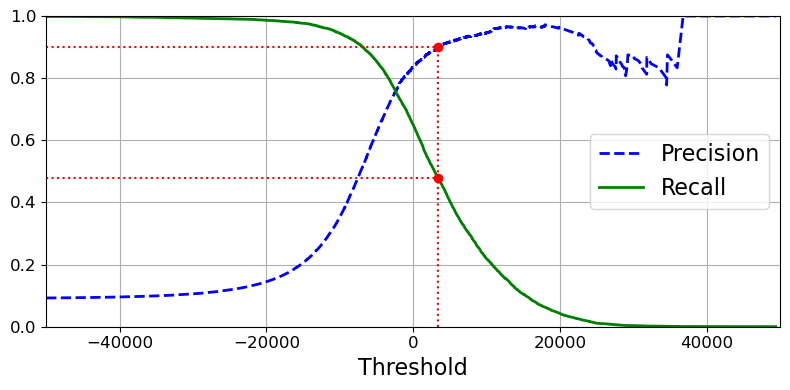

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [37]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


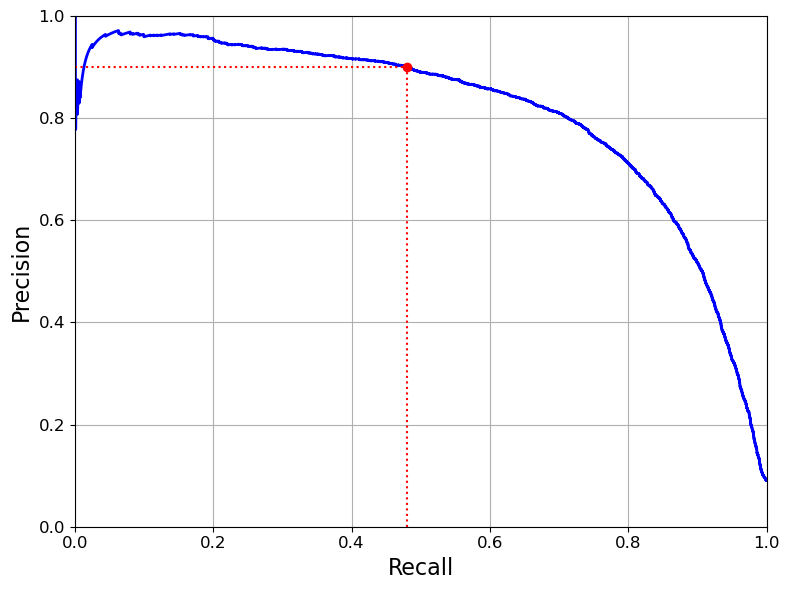

In [38]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

In [40]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [41]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [42]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Outra maneira de escolher um bom trade-off  de precisão/revocação é plotar a precisão diretamente em relação à revocação.

Pode ver que a precisão começa a diminuir acentuadamente em torno de 80% da revocação. Provavelmente quer escolher um trade-off de precisão/revocação mais do que depressa, antes dessa queda - por exemplo, com aproximadamente 60% de revocação. Mas, obviamente, a escolha depende do seu projeto.

Suponha que quer 90% de precisão, analisa primeiro o primeiro gráfico e descobre que precisa usar um limiar de cerca de 8 mil. Para ser mais exato, pode procurar o limiar mais baixo que fornece pelo menos 90% de precisão (a np.argmax() lhe dará o primeiro índice do valor máximo, que caso significa o primeiro valor True):

Ótimo, temos um classificador de precisão de 90%! Como pode ver, é bem fácil criar um classificador com basicamente toda a precisão que queremos: Basta definir um limiar alto o bastante. 

Um classificador de alta precisão não é lá muito útil, se sua revocação for muito baixa.

### A curva ROC

A curva de característica de operação(ROC) é outra ferramenta comum usada com classificadores binários. É muito semelhante á curva de precisão/revocação, mas, em vez de plotar precisão vs revocação, a curva ROC representa a taxa de verdadeiros positivos (outro nome para revocação) em relação à taxa de positivos falsos (FPR). O FPR é a proporção de instâncias negativas classificadas incorretamente como positivas.
É igual a 1 - a taxa de verdadeiros negativos (TNR), que é a proporção de instâncias negativas que são corretamente classificadas como negativas. O TNR também é chamado de especificidade. Portanto, a curva ROC representa a sensibilidade (revocação versus 1 - a especificidade).

Para plotar a curva ROC, primeiro use a função roc_curve() a fim de calcular o TPR e FPR para diversos valores de limiares:

In [43]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Em seguida, pode plotar o FPR em relação ao TPR usando a Matplotlib. O código a seguir gera o gráfico:

Saving figure roc_curve_plot


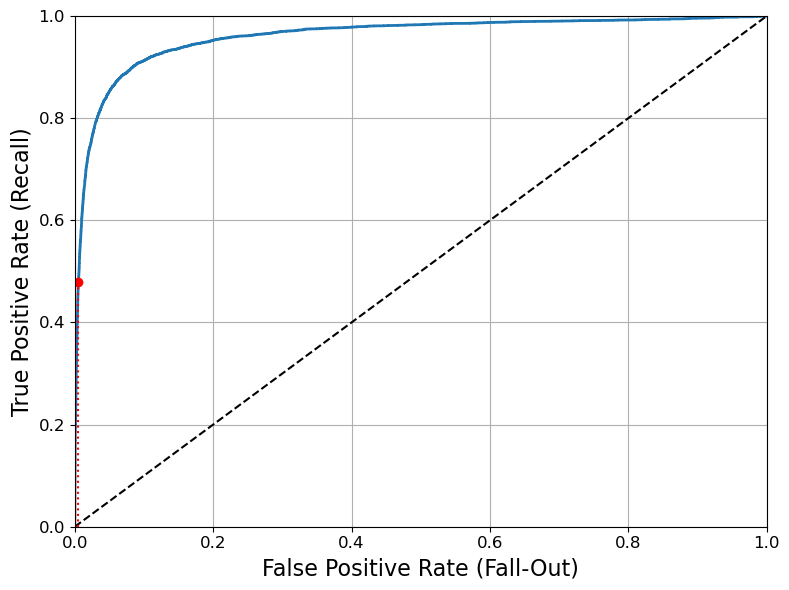

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal Tracejada
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

Mais uma vez, existe um trade-off: quanto maior a revocação (TPR), mais falsos positivos (FPR) o classificador produz. A linha pontilhada representa a curva ROC de um classificador exclusivamente aleatório; um bom classificador fica o mais distante possível dessa linha (em direção ao canto superior esquerdo).

Esta curva ROC representa a taxa de falsos positivos em relação à taxa de verdadeiros positivos para todos os limiares possíveis; o ponto no gráfico destaca a proporção escolhida (com 43,68% de revocação)

Uma forma de comparar os classificadores é calcular a área sob a curva (AUC). Um classificador perfeito terá uma ROC AUC igual a 1, enquanto um classificador exclusivo aleatório terá um ROC AUC igual a 0.5. A Scikit-Learn tem uma função para calcular o ROC AUC:

In [45]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Agora, vamos treinar um "RandomForestClassifier" e comparar sua curva "ROC" e score "ROC AUC" com as do SGDClassifier. Primeiro, precisa obter scores para cada instância no conjunto de treinamento. Contudo, devido ao modo como funciona, a classe "RandomForestClassifier" não tem um método "decision_function()". Em vez disso, ela tem um método "predict_proba()". Os classificadores da Scikit-Learn geralmente têm um ou outro, ou ambos. O método "predict_proba()" retorna um array que contém uma linha por instância e uma coluna por classe, cada uma com probabilidade de que a instância especificada pertença à classe especificada (por exemplo 70% de probabilidade de que a imagem representa um 5)

In [46]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

A função "roc_curve()" espera rótulos e scores, no entanto, em vez de scores, pode fornecer probabilidades de classe. Será usado a probabilidade da classe positiva como score:

In [47]:
y_scores_forest = y_probas_forest[:, 1] # score=probabilidade de classe positiva
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Agora, está preparado para plotar a curva ROC. Ajuda muito representar também a primeira curva ROC a fim de ver a comparação das duas

Saving figure roc_curve_SGD


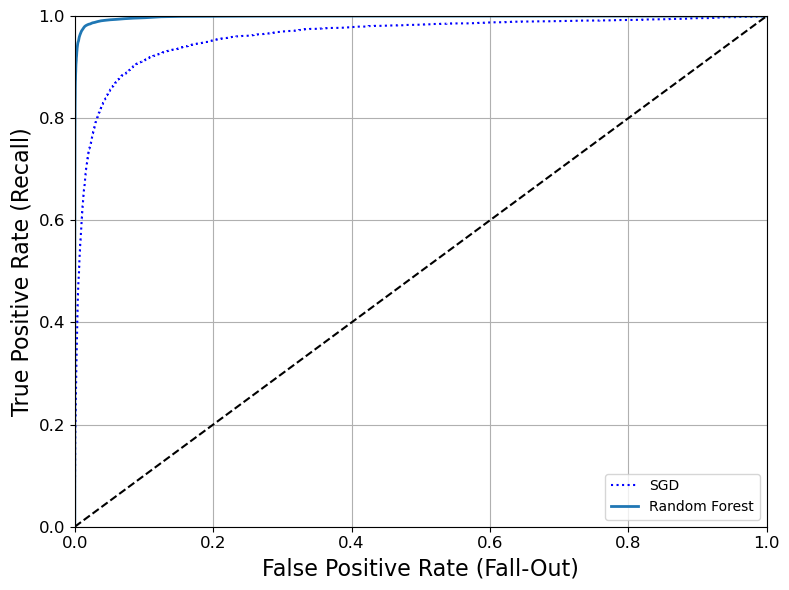

In [48]:
plt.figure(figsize=(8, 6))                                    # Not shown
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
save_fig("roc_curve_SGD")                                    # Not shown
plt.show()

Comparando curvas ROC: o classificador Random Forest é superior ao classificador SGD, porque sua curva ROC está mais próxima do canto superior esquerdo e tem uma AUC maior

### Classificação Multiclasse

Uma vez que os classificadores binários fazem distinções entre duas classes, os classificadores multiclasses (também chamados de classificadores multinomiais) podem distinguir entre mais de duas classes. 

Alguns algoritmos (como classificadores SGD, classificadores de florestas aleatórias e classificadores native Bayes) conseguem lidar com diversas classes de forma nativa. Outros (como classificadores de regressão logística ou máquina de vetores de suporte) são estritamente classificadores binários. No entanto, existem diversas estratégias que podemos usar para fazer a classificação em diversas classes com vários classificadores binários.

A Scikit-Learn detecta quando você tenta usar um algoritmo de classificação binário para uma tarefa de classificação em várias classes e executa automaticamente o OvR ou o OvO, dependendo do algoritmo. Tentaremos um algoritmo com um classificador de máquinas de vetores de suporte

In [49]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, e não  y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Esse código treina o "SVC" no conjunto de treinamento usando as classes alvos originais de 0 a 9 (y_train), em vez das classes alvos 5 versus-the-rest(y_train_5). Em seguida, faz uma predição (neste caso, uma predição correta). Nos bastidores, a Scikit-Learn usou a estratégia OvO: treinou 45 classificadores binários, obteve seus scores de decisão para a imagem e selecionou a classe que venceu mais desafios.

Se chamar o método "decision_function()", verá que ele retornou 10 scores por instância (em vez de apenas 1). É um score por classe.

In [50]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

O score mais alto é de fato o que corresponde à classe 5:

In [51]:
np.argmax(some_digit_scores)

5

In [52]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Quando um classificador é treinado, ele armazena a lista das classes-alvo no atributo classes_, ordenado por valor. Neste caso, o índice de cada classe no array classes_ bate convenientemente com a própria classe (por exemplo, a classe no índice 5 também é a classe 5).

Caso queira forçar o Scikit-Learn a usar a estratégia one-versus-one ou one-versus-the-rest, utilize as classes "OneVsOneClassifier" ou "OneVsRestClassifier". Basta criar uma instância e passar um classificador para seu construtor (nem precisa ser um classificador binário). Por exemplo, esse código cria um classificador multiclasse usando a estratégia OvR, com base em um svc:

In [53]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
len(ovr_clf.estimators_)

10

Treinar um 'SGDClassifier' (ou um RandomForestClassifier) é tão fácil quanto:

In [55]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

Dessa vez, a Scikit-Learn não precisou rodar o OvR ou o OvO, pois os classificadores SGD podem classificar diretamente as instâncias em várias classes. Agora, o método 'decision_function' retorna um valor por classe. Vejamos o score que o classficador SGD atribuiu a cada classe:

In [56]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Veja que o classificador está bastante confiante em relação à predição: quase todos os scores são amplamente negativos, enquanto a classe 5 tem um score de '2412,5'. O modelo tem uma pequena dúvida em relação à classe 3, que obtém um score '573,5'. Agora, tem que avaliar esse classificador. Como de costume, pode usar a validação cruzada. Usar a função 'cross_val_score()' para avaliar a acurácia do 'SGDClassifier':
        

In [57]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Obteve mais de '87%' em todos os folds de teste. Se usasse um classificador aleatório, obteria uma acurácia de '10%', não é um score tão ruim, mas ainda pode fazer melhor. Basta fazer o escalonamento das entradas, para aumentar a acurácia acima de '89%'

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Análise de Erro

Se estivesse trabalhando em um projeto real, seguiria as etapas de seu checklist do projeto de aprendizado de máquina. Exploraria as opções de preparação de dados, testaria diversos modelos (selecionando os melhores e aperfeiçoando seus hiperparâmetros usando o 'GridSearch') e automatizaria o processo o máximo possível. Vamos imaginar que encontramos um modelo promissor e quer identificar maneiras de melhorá-lo. Um modo de fazer isso é analisar os tipos de erros que esse modelo comete.
Primeiro, análise a matriz de confusão. É necessário realizar as predições usando a função 'cross_val_predict()' e depois chamar a função 'confusion_matrix()'.

In [59]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [60]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Visualizar uma representação de imagem da matriz de confusão usando a função 'matshow()' do Matplotlib:

In [61]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


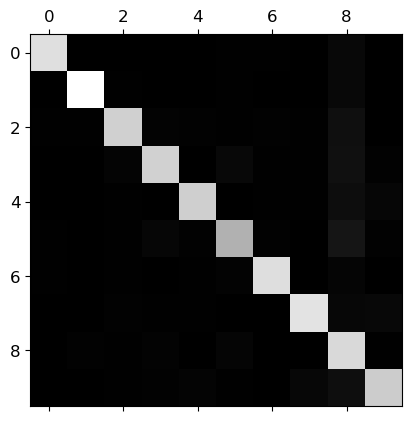

In [62]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

Essa matriz de confusão é muito boa, pois grande parte das imagens está na diagonal, o que significa que foram classificadas corretamente.

Vamos focar na representação dos erros. Primeiro, precisa dividir cada valor na matriz de confusão pelo número de imagens na classe correspondente, de modo que consiga comparar as taxas de erro, em vez de números absolutos de erros(o que faria com que as classes numerosas parecessem injustamente ruins):

In [63]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Preencha a diagonal com zeros para manter somente os erros e plotar o resultado:

Saving figure confusion_matrix_errors_plot


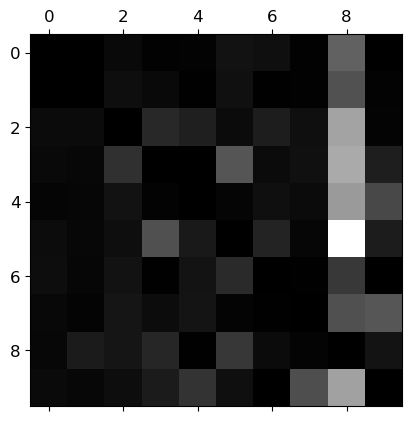

In [64]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Vamos plotar os exemplos de 3s e 5s (a função 'plot_digits()' usa somente a função 'imshow()' da Matplotlib)

In [65]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

Saving figure error_analysis_digits_plot


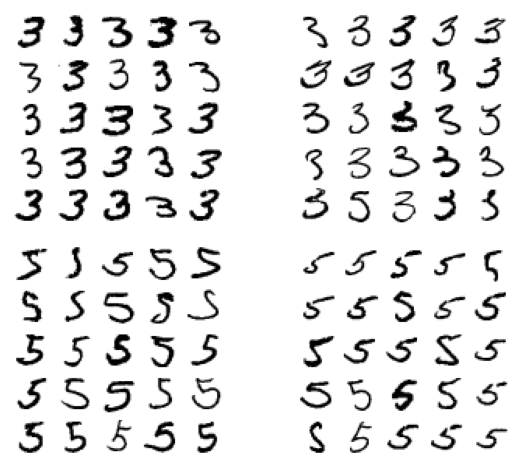

In [66]:
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

### Classificação Multirrótulo

Cada instância sempre foi atribuída a somente uma classe. Em alguns casos, pode querer que seu classificador gere a saída de várias classes para cada instância. Considere um classificador de reconhecimento facial: o que ele deve fazer se reconhecer diversas pessoas na mesma imagem? Ele deve anexar um rótulo para cada pessoa que reconhece.

Veremos um exemplo mais simples, apenas para ilustrar as coisas:

In [67]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Esse código cria um array y_multilabel contendo dois rótulos-alvo para cada imagem de algarismo: o primeiro indica se o algarismo é grande (7, 8 ou 9) ou não, e o segundo indica se é impar ou não. As próximas linhas criam uma instância 'KNeighborsClassifier' que comporta a classificação multirótulo, embora nem todos os classificadores comportem, assim treinamos usando o array para múltiplos alvos. Agora conseguimos realizar uma predição. Repare que o código gera a saída de dois rótulos:

In [68]:
knn_clf.predict([some_digit])

array([[False,  True]])

Existem diversas formas de avaliar um classificador multirótulo, e escolher a métrica correta realmente depende do projeto. Uma abordagem é calcular o F, score para cada rótulo individual (ou qualquer outra métrica de classificador binário) e depois simplesmente calcular o score médio. O código a seguir contabiliza o F, score em todos os rótulo:

In [69]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [70]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

Isso pressupõe que todos os rótulos são importantes, o que pode não ser o caso. Em particular, se tiver muito mais fotos de Alice do que de Bob ou Charlie, convém dar mais peso ao score do classificador nas fotos de Alice. Uma opção simples é atribuir um peso igual ao seu support ou seja, o número de instâncias com esse rótulo-alvo. Para fazer isso, basta definir "average=weighted" no código anterior.

### Classificação Multioutput

O último tipo de tarefa de classificação que será analisado se chama "classificação multioutput". É simplesmente uma generalização da classificação multirrótulo, em que cada rótulo pode ser multiclasseada ou seja, pode ter mais dois valores possíveis.

Com o objetivo de exemplificá-la, criaremos um sistema que remove o ruído das imagens. Ele terá como entrada uma imagem de algarismo com ruído e gerará uma saída de uma imagem de algarismo limpo, representada como um array de intensidade de pixel, assim como as imagens do MNIST. Repare que a saída do classificador é multirrotulada (um rótulo por pixel) e cada rótulo pode ter vários valores (a intensidade do pixel varia de 0 a 255). Logo, é um exemplo de um sistema de classificação multioutput.

Vamos começar criando os conjuntos de treinamento e teste, usando as imagens do MNIST e adicionando ruído às suas intensidades de pixel com a função "randint()" do NumPy. As imagens-alvo serão as imagens originais.

In [71]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

À esquerda, a imagem da entrada com rótulo; e à direita, a imagem-alvo limpa. Agora vamos treinar o classificador e limpar essa imagem:

Saving figure noisy_digit_example_plot


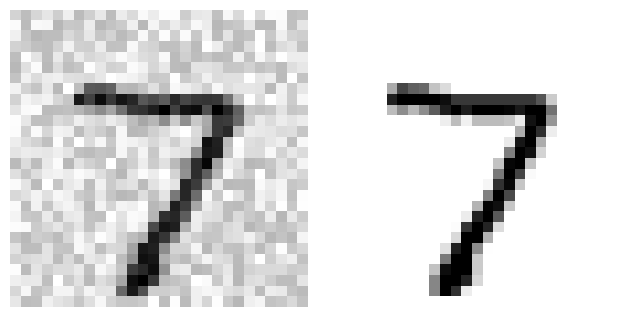

In [72]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


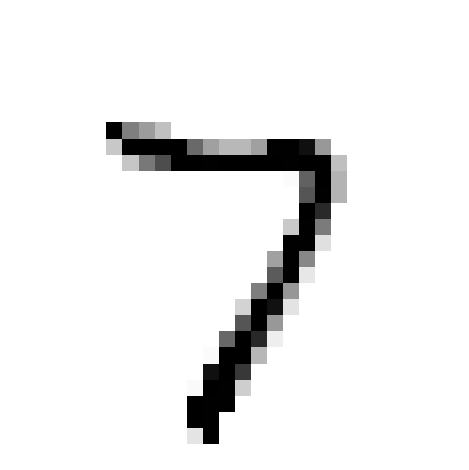

In [73]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

Parece bem próximo da imagem-alvo! Isso conclui nosso tour de classificação. Agora, já sabe como escolher boas métricas para tarefas de classificação, escolher o trade-off de precisão/revocação apropriado, comparar classificadores e, em termos mais gerais, criar bons sistemas de classificação para uma variedade de tarefas.